In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.special import spherical_jn
from tqdm import tqdm

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [3]:
# Compute the Mott-Massey results
mm = LocalSystem(1.5)
mm_vtilde = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)
mm_evals, mm_evecs = bind.bound_states(mm_vtilde, 0, 0, mm.q, mm.wq)

In [4]:
def ftr(state, r, q, wq):
    y = np.array([np.sum(np.sqrt(2/np.pi) * wq * q**2 * state * spherical_jn(0, q*ri)) for ri in r])
    return 1/np.sqrt(np.sum(ls.r_weights * ls.r_nodes**2 * y**2)) * y


def local_LO_counterterm(r, R):
    return np.exp(-(r/R)**4)


def local_NLO_counterterm(r, R):
    derivative_factor = (16*r**6 - 12*r**2*R**4) / R**8
    return derivative_factor * local_LO_counterterm(r, R)


def psi0(ls, g, ii, full=False):
    evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)
    psi0 = np.zeros(7)
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
        if full:
            psi0[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_NLO_counterterm(ls.r_nodes, Ri) * psi**2)
        else:
            psi0[i] = psi[ii]**2
    return psi0


def psi_Vnlo_psi(evals, evecs, R):
    overlap = np.zeros(7)
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
        overlap[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_NLO_counterterm(ls.r_nodes, R) * psi**2)
    return overlap


def f_min(c2, evals, evecs, R):
    overlap = psi_Vnlo_psi(evals, evecs, R)
#     return np.linalg.norm(mm_evals[-2:] - (evals[-2:] + c2*overlap[-2:]))
    return (mm_evals[5] - (evals[5] + c2*overlap[5]))

In [5]:
Rs, gs = np.loadtxt('rgflow_local_B6_fix.txt', unpack=True)

In [6]:
Ri = Rs[0]
gi = gs[0]
ls = LocalSystem(Ri)
evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(gi, 0), 1, ls.q, ls.wq)

In [18]:
guess = -0.00282
f_min(guess, evals, evecs, Ri)

-1.1329605058155515e-08

In [22]:
class Spectrum:
    def __init__(self, evals, evecs, R, g_nlo):
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = R
        self.g_nlo = g_nlo
        
        self.overlap = psi_Vnlo_psi(self.lo_evals, self.lo_evecs, self.R)
        self.nlo_evals = self.lo_evals + self.g_nlo*self.overlap
        self.nlo_evals[-1] = self.lo_evals[-1]

In [23]:
gnlos = np.zeros(Rs.size)
specs = []

In [24]:
from scipy.interpolate import interp1d

In [26]:
for (i, (Ri, gi)) in enumerate(zip(Rs, gs)):
    ls = LocalSystem(Ri)
    evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(gi, 0), 1, ls.q, ls.wq)
    result = optimize.fsolve(f_min, guess, args=(evals, evecs, Ri))
    gnlo = result[0]
    
    gnlos[i] = gnlo
    specs.append(Spectrum(evals, evecs, Ri, gnlo))
    
    if i < 5:
        guess = gnlo
    else:
        curve = interp1d(Rs[i-5:i], gs[i-5:i], kind='cubic')
        try:
            guess = curve(Rs[i+1])
        except:
            pass
    
    print(f'i = {i}  R = {Ri:.4e}  g_nlo = {gnlo:.4e}')

i = 0  R = 2.0444e+00  g_nlo = -2.8184e-03
i = 1  R = 2.0131e+00  g_nlo = -2.9013e-03
i = 2  R = 1.9818e+00  g_nlo = -2.9653e-03
i = 3  R = 1.9505e+00  g_nlo = -2.9576e-03
i = 4  R = 1.9192e+00  g_nlo = -2.9117e-03
i = 5  R = 1.8879e+00  g_nlo = -2.8826e-03
i = 6  R = 1.8566e+00  g_nlo = -2.8343e-03
i = 7  R = 1.8253e+00  g_nlo = -2.7555e-03
i = 8  R = 1.7940e+00  g_nlo = -2.6862e-03
i = 9  R = 1.7627e+00  g_nlo = -2.5621e-03
i = 10  R = 1.7315e+00  g_nlo = -2.4278e-03
i = 11  R = 1.7002e+00  g_nlo = -2.2718e-03
i = 12  R = 1.6689e+00  g_nlo = -2.0670e-03
i = 13  R = 1.6376e+00  g_nlo = -1.8146e-03
i = 14  R = 1.6063e+00  g_nlo = -1.5392e-03
i = 15  R = 1.5750e+00  g_nlo = -1.2791e-03
i = 16  R = 1.5437e+00  g_nlo = -1.0293e-03
i = 17  R = 1.5124e+00  g_nlo = -8.7795e-04
i = 18  R = 1.4811e+00  g_nlo = -9.1453e-04
i = 19  R = 1.4498e+00  g_nlo = -1.1825e-03
i = 20  R = 1.4185e+00  g_nlo = -1.7316e-03
i = 21  R = 1.3872e+00  g_nlo = -2.7348e-03
i = 22  R = 1.3560e+00  g_nlo = -4.2344e-0

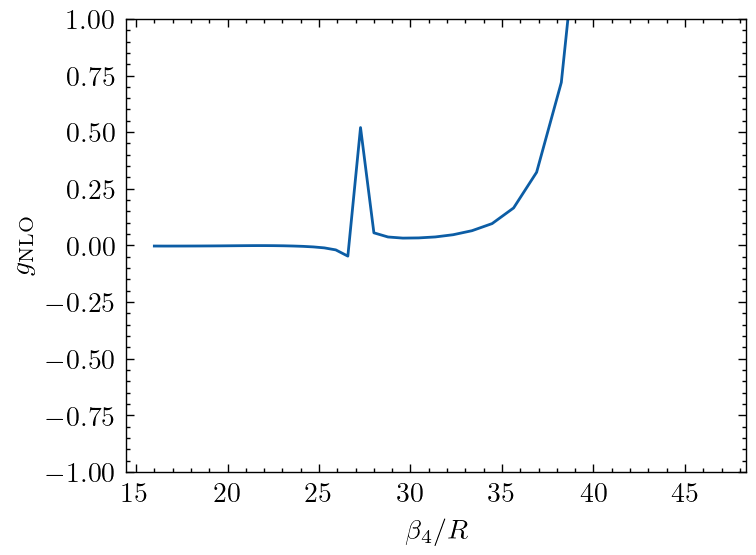

In [34]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(const.BETA4/Rs, gnlos)

ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$g_{\rm NLO}$');

In [28]:
lo_specs = np.array([spec.lo_evals for spec in specs])
nlo_specs = np.array([spec.nlo_evals  for spec in specs])

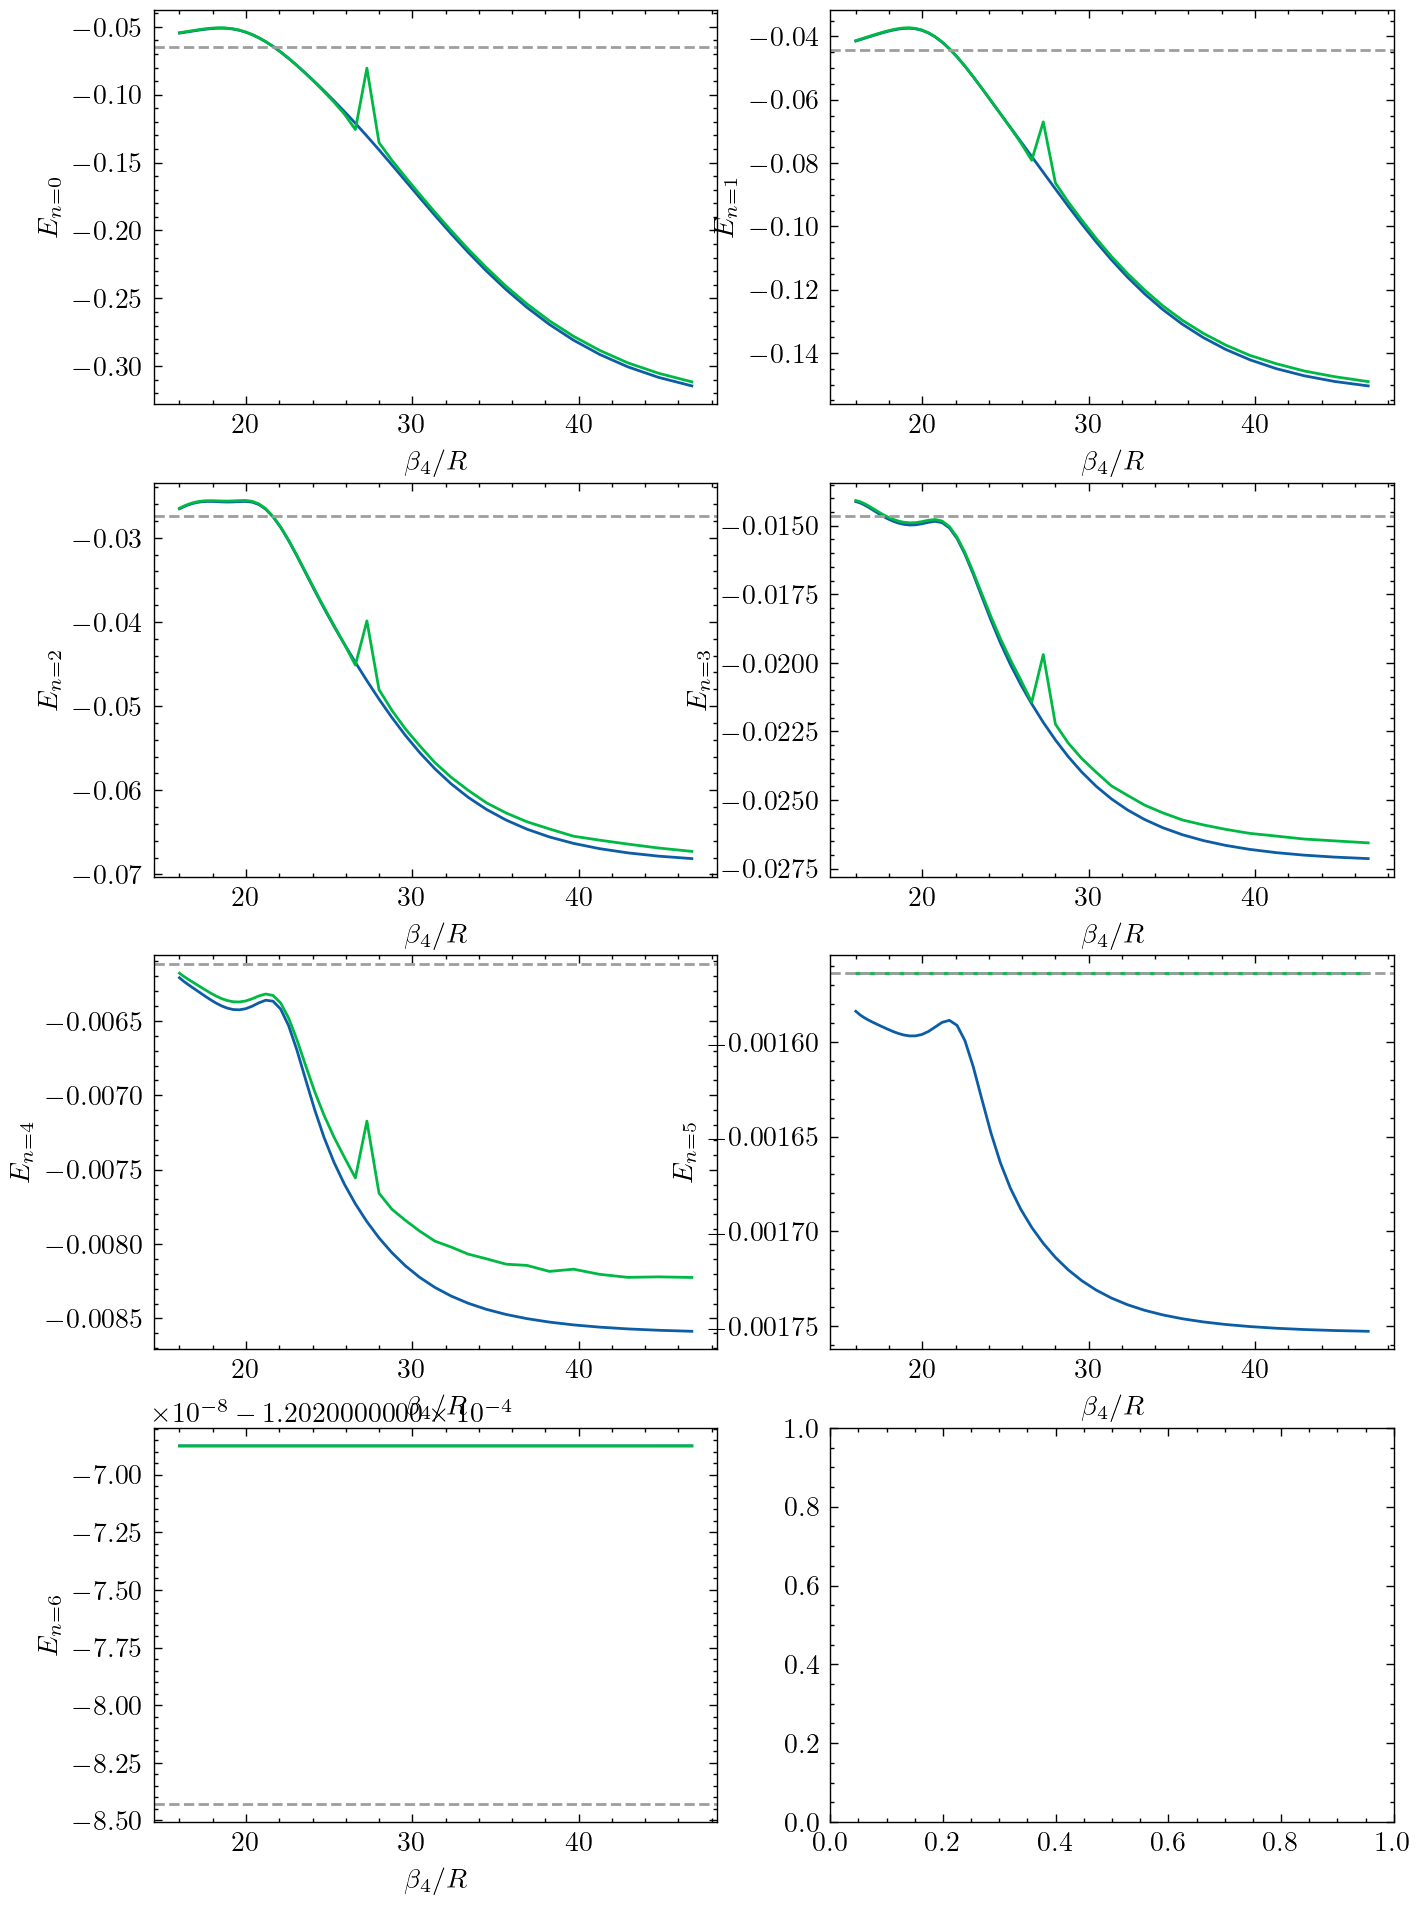

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, lo_specs[:, i])
    ax[i//2, i%2].plot(const.BETA4/Rs, nlo_specs[:, i])
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i));

In [30]:
all_overlaps = np.array([spec.overlap for spec in specs])

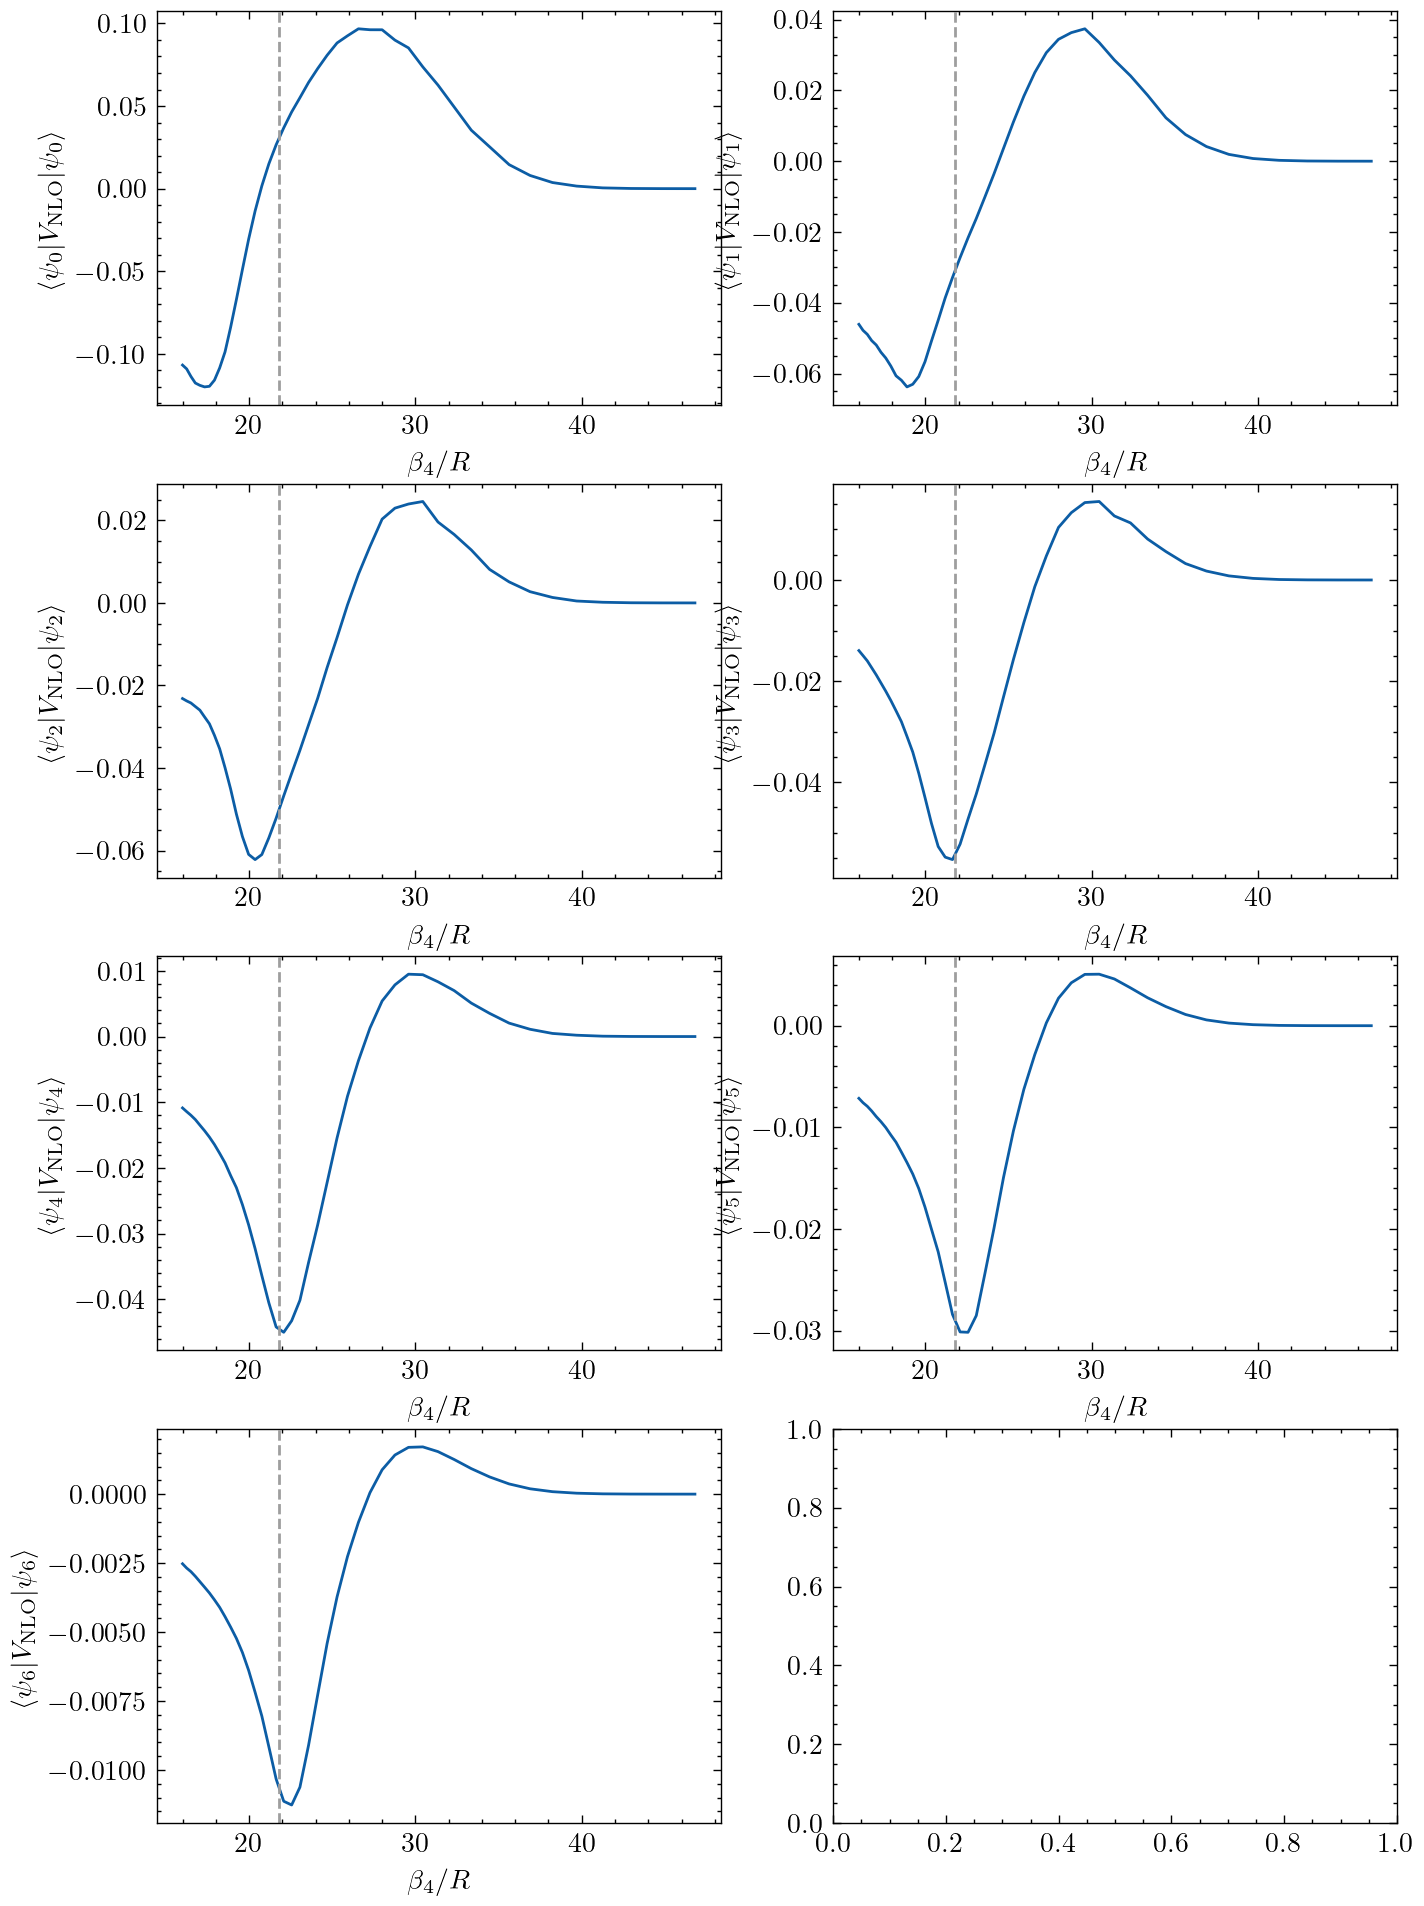

In [31]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, all_overlaps[:, i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$\langle\psi_{%d}|V_{\rm NLO}|\psi_{%d}\rangle$' % (i, i))
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

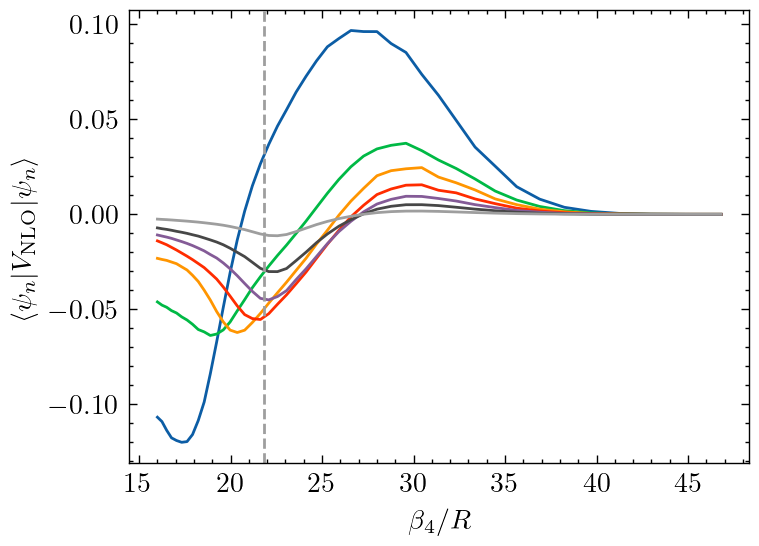

In [35]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs, all_overlaps[:, i])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$\langle\psi_{n}|V_{\rm NLO}|\psi_{n}\rangle$')
ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')

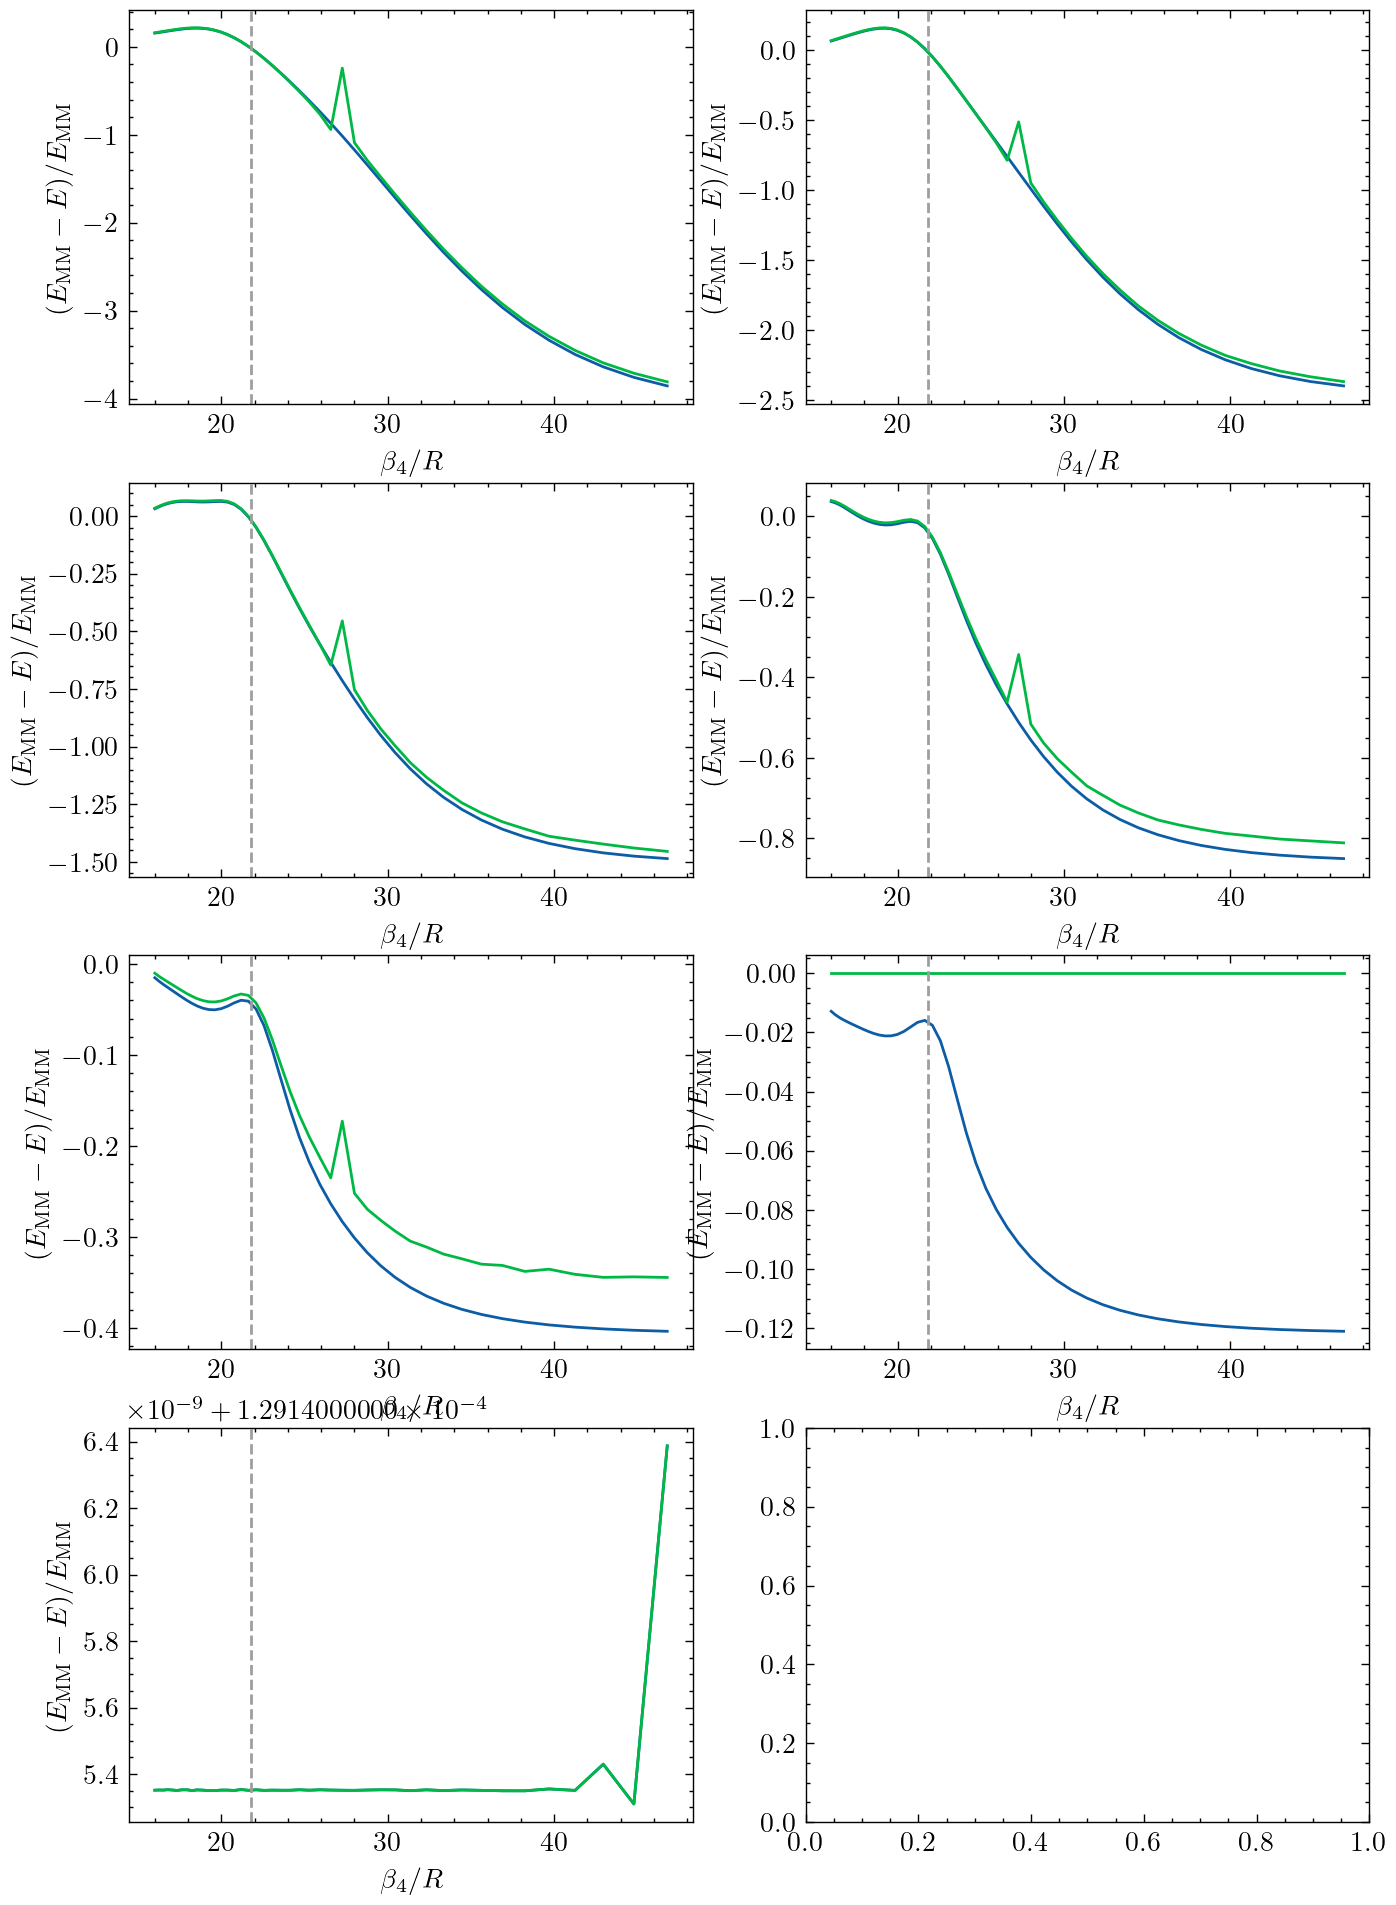

In [33]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - lo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - nlo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')